In [271]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np


Load & examine data

In [272]:
tab=pd.read_csv("Weekly_Rates_of_Laboratory-Confirmed_RSV_Hospitalizations_from_the_RSV-NET_Surveillance_System_20251224.csv.gz",compression="gzip").drop_duplicates()
tab

,State,Season,Week ending date,Age Category,Sex,Race,Rate,Cumulative Rate,Type
0,Utah,2022-23,2023-09-30,All,All,All,0.1,78.7,Crude Rate
1,Utah,2022-23,2023-09-23,All,All,All,0.0,78.6,Crude Rate
2,Utah,2022-23,2023-09-16,All,All,All,0.1,78.6,Crude Rate
3,Utah,2022-23,2023-09-09,All,All,All,0.1,78.5,Crude Rate
4,Utah,2022-23,2023-09-02,All,All,All,0.1,78.4,Crude Rate
...,...,...,...,...,...,...,...,...,...
206266,RSV-NET,2025-26 (All Ages),2025-10-18,All,All,"A/PI, non-Hispanic",0.1,0.1,Age adjusted Rate
206267,RSV-NET,2025-26 (All Ages),2025-12-06,All,All,Hispanic,0.5,2.3,Age adjusted Rate
206268,RSV-NET,2025-26 (All Ages),2025-10-25,All,All,Hispanic,0.1,0.3,Age adjusted Rate
206269,RSV-NET,2025-26 (All Ages),2025-11-22,All,All,"AI/AN, non-Hispanic",1.0,1.5,Age adjusted Rate


First, let's subset to data only for total US (not individual states), all sex, all race, and crude rate only.

In [273]:
relevant = tab[
    (tab["State"] == "RSV-NET") &
    (tab["Race"] == "All") &
    (tab["Type"] == "Crude Rate") & 
    (tab["Sex"] == "All")
].drop(columns=["State","Race","Type","Sex"])
# Ensure date column is datetime
#relevant["Week ending date"] = pd.to_datetime(relevant["Week ending date"])


In [274]:
#Ensure date column is datetime
relevant["Week ending date"]

18720     2023-09-30
18721     2023-09-23
18722     2023-09-16
18723     2023-09-09
18724     2023-09-02
             ...    
202233    2017-04-08
202234    2017-04-15
202235    2017-04-22
202236    2017-04-29
202237    2017-05-06
Name: Week ending date, Length: 8375, dtype: object

In [275]:
pd.to_datetime(relevant["Week ending date"])


18720    2023-09-30
18721    2023-09-23
18722    2023-09-16
18723    2023-09-09
18724    2023-09-02
            ...    
202233   2017-04-08
202234   2017-04-15
202235   2017-04-22
202236   2017-04-29
202237   2017-05-06
Name: Week ending date, Length: 8375, dtype: datetime64[ns]

In [276]:
relevant

,Season,Week ending date,Age Category,Rate,Cumulative Rate
18720,2022-23,2023-09-30,All,0.7,54.6
18721,2022-23,2023-09-23,All,0.6,53.9
18722,2022-23,2023-09-16,All,0.4,53.4
18723,2022-23,2023-09-09,All,0.4,53.0
18724,2022-23,2023-09-02,All,0.3,52.6
...,...,...,...,...,...
202233,2016-17,2017-04-08,≥65 years,0.4,30.6
202234,2016-17,2017-04-15,≥65 years,0.2,30.8
202235,2016-17,2017-04-22,≥65 years,0.3,31.2
202236,2016-17,2017-04-29,≥65 years,0.3,31.4


It seems that "season" does not directly correspond to year. Let us examine how this breaks down...

In [277]:
x=relevant["Season"].unique()
x.sort()
x

array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22',
       '2022-23', '2023-24', '2024-25', '2025-26'], dtype=object)

In [278]:
len(relevant[relevant["Season"]=="2022-23"]["Week ending date"].unique())

52

Confirmed that one entry is one week.

My understanding is that `rate` is "rate per 100,000" people https://www.cdc.gov/rsv/php/surveillance/rsv-net.html

Given that the proposed changes to vaccination would potentially abrogate treatments for specific age groups, forcasting the effect requires that we focus on those age groups. Current CDC guidance is 


> CDC recommends RSV vaccination for all adults ages 75 and older and for adults ages 50–74 who are at increased risk of severe RSV.
> To protect infants from severe RSV, CDC recommends an RSV vaccine for pregnant women (Pfizer's Abrysvo) or an infant RSV antibody given to the baby.
> Nirsevimab is also recommended for a small group of young children ages 8–19 months entering their second RSV season. Clesrovimab has not been recommended for this group.

(see [Wayback link: Clinical Overview of RSV](https://web.archive.org/web/20251225014051/https://www.cdc.gov/rsv/hcp/clinical-overview/index.html)).

We are going to focus on childhood.


In [279]:
relevant["Age Category"].unique()

array(['All', '≥18 years (Adults)', '0-17 years (Children)', '≥75 years',
       '1-4 years', '0-<1 year', '≥85 years', '75-84 years',
       '65-74 years', '40-49 years', '30-39 years', '18-29 years',
       '12-17 years', '5-11 years', '2-4 years', '1-<2 years',
       '6mo-<12 months', '0-<6 months', '≥65 years', '50-64 years',
       '18-49 years', '5-17 years', '0-4 years'], dtype=object)

In [280]:
a="0-<6 months"
targets = {
    a,
#    "≥75 years",
#    "50-64 years",
#    "65-74 years",
}

relevant_ages = relevant[
    relevant["Age Category"].str.strip().isin(targets)
]

relevant_ages=relevant_ages.drop(columns=["Age Category","Cumulative Rate"])
#relevant_ages=relevant(relevant["Age Category"] in ["0-17 years (Children)", "≥75 years", "50-64 years", "65-74 years"])

In [281]:
relevant_ages

,Season,Week ending date,Rate
19968,2022-23,2023-09-30,23.5
19969,2022-23,2023-09-23,27.0
19970,2022-23,2023-09-16,13.2
19971,2022-23,2023-09-09,13.2
19972,2022-23,2023-09-02,13.8
...,...,...,...
191934,2025-26,2025-11-01,6.2
191935,2025-26,2025-10-25,6.7
191936,2025-26,2025-10-18,6.7
191937,2025-26,2025-10-11,6.7


We want "five years before and after". However this is a tad challenging, given seasonality, recency, and confounding effects of COVID. Let's do "5 seasons before vaccienes, but exclusing covid".

In [282]:
#before=['2018-19', '2019-20']
before=['2016-17', '2017-18', '2018-19', '2019-20']# '2020-21'
after=['2024-25', '2025-26']

Subset to relevant years...

In [283]:

relevant_ages["period"] = np.select(
    [
        relevant_ages["Season"].isin(before),
        relevant_ages["Season"].isin(after),
    ],
    [
        "before",
        "after",
    ],
    default=pd.NA
)

# Drop seasons not in either list
relevant_ages = relevant_ages.dropna(subset=["period"])
relevant_ages

,Season,Week ending date,Rate,period
81016,2024-25,2025-09-27,2.4,after
81017,2024-25,2025-09-20,2.4,after
81018,2024-25,2025-09-13,1.2,after
81019,2024-25,2025-09-06,2.4,after
81020,2024-25,2025-08-30,1.2,after
...,...,...,...,...
191934,2025-26,2025-11-01,6.2,after
191935,2025-26,2025-10-25,6.7,after
191936,2025-26,2025-10-18,6.7,after
191937,2025-26,2025-10-11,6.7,after


In [284]:
max(relevant_ages["Rate"])

124.9

In [285]:
min(relevant_ages["Rate"])

0.0

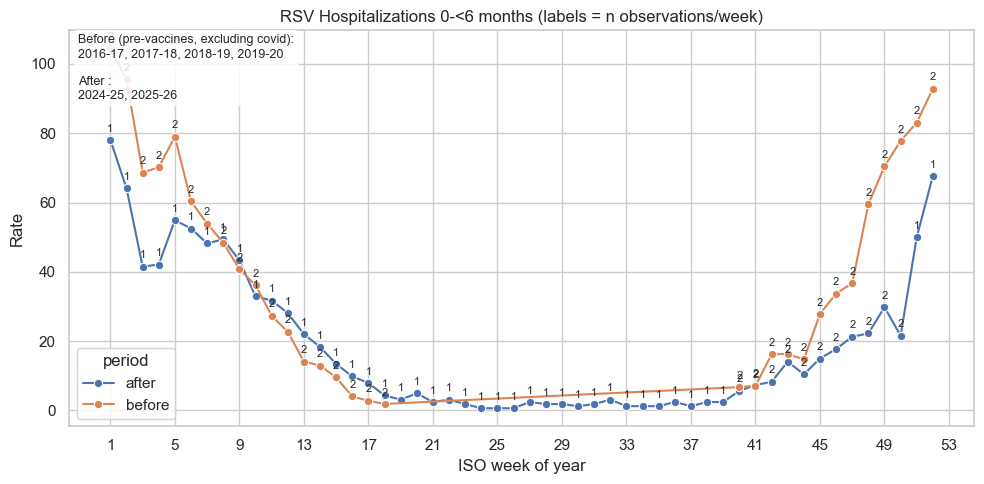

In [286]:
df = relevant_ages.copy()
df = df.drop(columns=["Season"])

df["Week ending date"] = pd.to_datetime(df["Week ending date"])
df["iso_week"] = df["Week ending date"].dt.isocalendar().week.astype(int)

# Aggregate: mean + count
plot_df = (
    df.groupby(["period", "iso_week"], as_index=False)
      .agg(rate_mean=("Rate", "mean"),
           n=("Rate", "size"))
)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=plot_df,
    x="iso_week",
    y="rate_mean",
    hue="period",
    marker="o"
)

# annotate counts at each point
for _, r in plot_df.iterrows():
    ax.annotate(
        str(int(r["n"])),
        (r["iso_week"], r["rate_mean"]),
        textcoords="offset points",
        xytext=(0, 6),
        ha="center",
        fontsize=8
    )

text = (
    "Before (pre-vaccines, excluding covid):\n"
    + ", ".join(before)
    + "\n\nAfter :\n"
    + ", ".join(after)
)

plt.gca().text(
    0.01, 0.99,
    text,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

plt.xlabel("ISO week of year")
plt.ylabel("Rate")
plt.title(f"RSV Hospitalizations {a} (labels = n observations/week)")
plt.xticks(range(1, 54, 4))
plt.tight_layout()
plt.show()

In [287]:
plot_df

,period,iso_week,rate_mean,n
0,after,1,78.10,1
1,after,2,64.10,1
2,after,3,41.50,1
3,after,4,42.10,1
4,after,5,54.90,1
...,...,...,...,...
78,before,48,59.45,2
79,before,49,70.45,2
80,before,50,77.80,2
81,before,51,83.05,2
